In [1]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split

from torchvision.transforms import v2

import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

In [2]:
df = pd.read_csv('../res/prepared_data.csv')

In [3]:
df.head()

,competition_id,season,round,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,...,month,day,dayofweek,home_club_formation_code,away_club_formation_code,net_transfer_record_home_num,net_transfer_record_away_num,stadium_code,stadium_name_home_code,stadium_name_away_code
0,-1.270845,-1.315944,-1.281584,-0.374854,-0.374635,3.0,3.0,-0.249495,-0.080008,-1.294868,...,0.356065,-0.544828,0.859005,-0.786416,-0.811003,0.374295,-0.086558,-1.456036,-1.470120,-1.439102
1,-1.270845,-1.315944,-1.281584,-0.376031,-0.369285,0.0,1.0,0.755516,-0.480396,-1.292192,...,0.356065,-0.656934,0.293306,-0.629760,0.275239,0.105489,0.050652,-1.448966,-1.463678,-0.730257
2,-1.270845,-1.315944,-1.225685,-0.376855,-0.376775,2.0,1.0,-1.656509,1.121156,-1.289517,...,0.356065,0.239909,0.859005,-0.786416,-0.655825,-0.776929,0.103620,-1.441897,-1.457235,-1.464878
3,-1.270845,-1.315944,-1.169787,-0.376031,-0.376657,0.0,2.0,1.760526,0.320380,-1.292192,...,0.356065,1.024647,0.859005,-0.629760,-0.811003,0.105489,1.440217,-1.448966,-1.463678,2.607757
4,-1.270845,-1.315944,-1.113888,-0.376855,-0.374635,6.0,2.0,-1.656509,1.121156,-1.289517,...,0.619340,-0.208512,0.293306,-0.786416,1.827013,-0.776929,-0.086558,-1.441897,-1.457235,-1.439102


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Підготовка даних

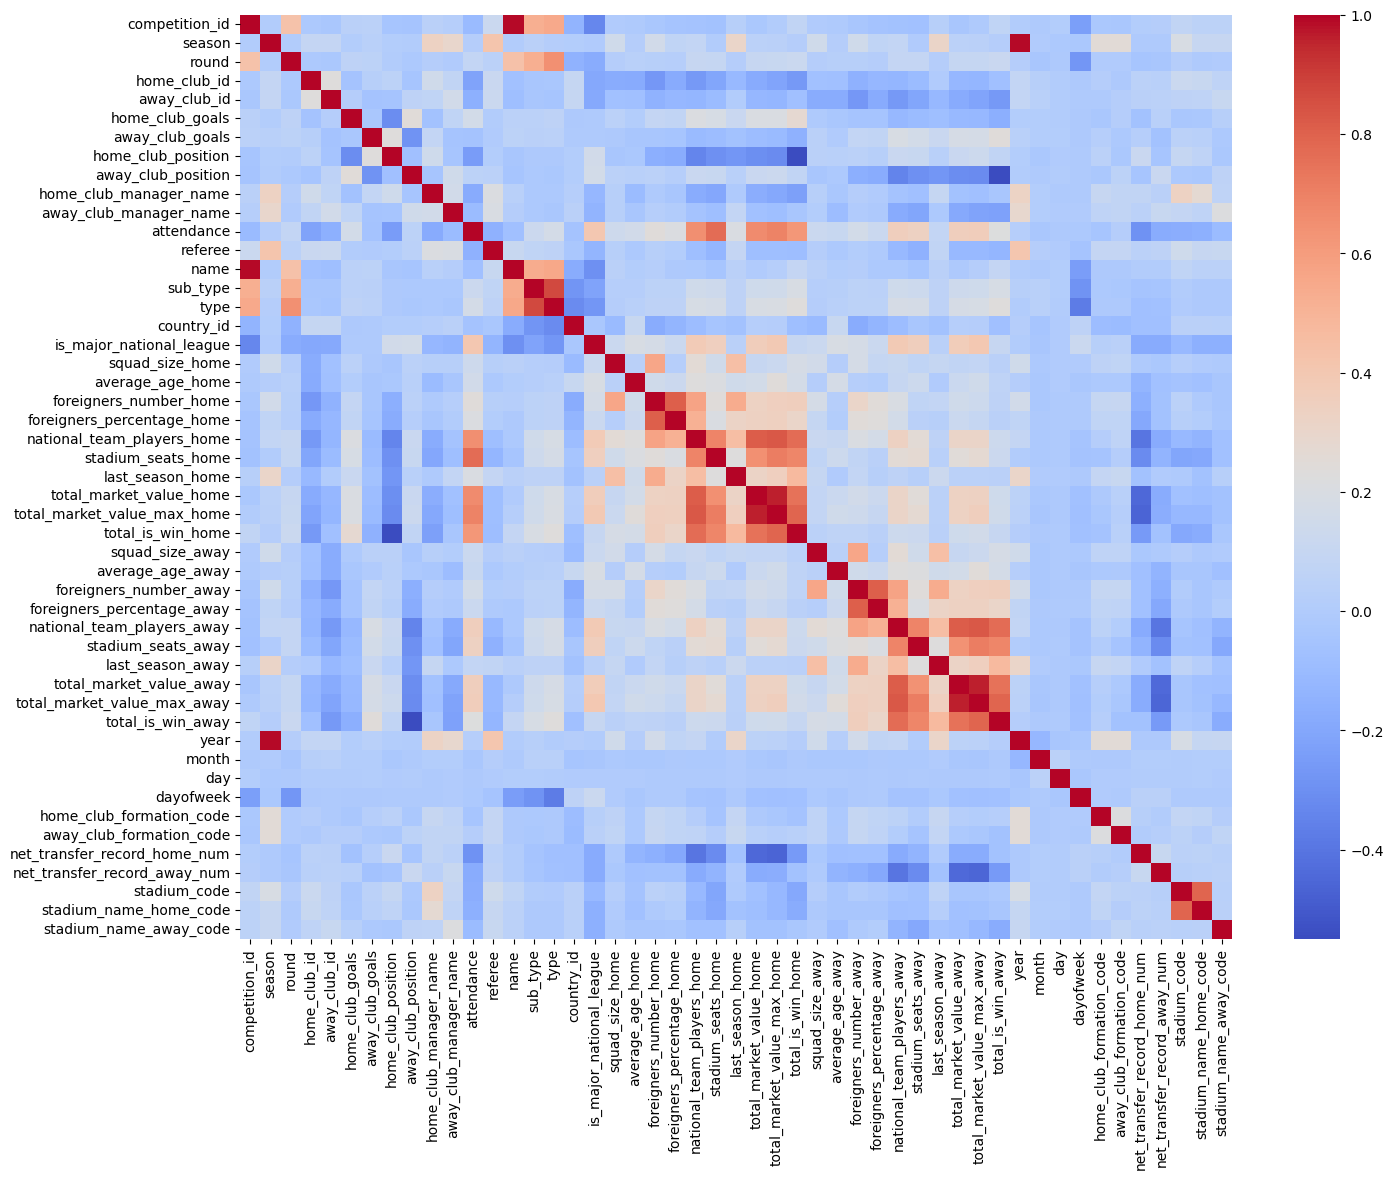

In [5]:
import seaborn as sns
corr_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [6]:
df['is_major_national_league'] = df['is_major_national_league'].astype(float)

In [7]:
X = df.drop(['home_club_goals', 'away_club_goals'], axis=1)
y = df[['home_club_goals', 'away_club_goals']]

In [8]:
# Перетворити X, y у тензори
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device)

# Створити датасет
dataset = TensorDataset(X_tensor, y_tensor)

In [9]:
# Розділити
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Створення моделі

In [11]:
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 64)
        self.layer_2 = nn.Linear(64, 32, bias=False)
        self.layer_3 = nn.Linear(32, 8)
        self.layer_4 = nn.Linear(8, output)

        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.bn2 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.layer_2(x)
        x = self.bn2(x)
        x = self.act(x)
        # x = self.dropout(x)

        x = self.layer_3(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.layer_4(x)

        return x

In [12]:
model = MyModel(len(X.columns), len(y.columns)).to(device)

In [13]:
data = torch.rand([128, len(X.columns)], dtype=torch.float32).to(device)

out = model(data)
out.shape

torch.Size([128, 2])

In [14]:
# Визначаємо функцію втрат і оптимізації градієнтного спуску
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.1)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode='min',
    factor=0.1,
    patience=5
)

# Тренування моделі

In [15]:
EPOCHS = 30
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []

In [16]:
# Цикл навчання
for epoch in range(EPOCHS):
    model.train()
    running_train_loss = [] # Для збереження втрат на кожному батчі
    correct_train = 0
    total_train = 0

    train_loop = tqdm(train_loader, leave=False) # при (leave=False) прогрес буде видалятися з консолі, щоб не засмічувати її
    for x, targets in train_loop:
        # Пряме поширення, розрахунок помилки
        pred = model(x) # Розраховуємо результати передбачень
        loss = loss_model(pred, targets) # Розраховуємо на скільки модель помилилась

        # Зворотне поширення похибки
        opt.zero_grad() # Обнуляємо раніше розраховані градієнти
        loss.backward() # Розраховуємо вплив нейронів на отриману похибку

        # Оптимізація
        opt.step() # Виконуємо корегування нейронів

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)

        # --- Accuracy ---
        diff = torch.abs(pred - targets)
        correct_train += ((diff <= 0.5).all(dim=1)).sum().item()  # обидва голи в межах 0.5
        total_train += targets.size(0)

        train_loop.set_description(f'Epoch [{epoch + 1} / {EPOCHS}], train_loss = {mean_train_loss:.4f}, train_val = {(correct_train / total_train):.4f}')

    # Збереження значення функції втрат і метрик
    train_loss.append(mean_train_loss)
    train_acc.append(correct_train / total_train)

    # Перевірка моделі
    model.eval()
    running_val_loss = []
    correct_val = 0
    total_val = 0
    with torch.no_grad(): # Забороняємо розрахунок градієнтів для цього блоку
        for x, targets in val_loader:
            # Пряме поширення, розрахунок помилки
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())

            # --- Accuracy ---
            diff = torch.abs(pred - targets)
            correct = ((diff <= 0.5).all(dim=1)).sum().item()
            correct_val += correct
            total_val += targets.size(0)


    # Збереження значення функції втрат і метрик
    mean_val_loss = sum(running_val_loss) / len(running_val_loss)
    val_loss.append(mean_val_loss)
    val_acc.append(correct_val / total_val)

    # Зміна швидкості навчання
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler.get_last_lr()[0]
    lr_list.append(lr)

    print(f'Epoch [{epoch + 1} / {EPOCHS}], train_loss={mean_train_loss:.4f}, val_loss={mean_val_loss:.4f}, train_acc={train_acc[-1]:.4f}, val_acc={val_acc[-1]:.4f}, lr={lr:.4f}')

Epoch [1 / 30], train_loss=1.5924, val_loss=1.5641, train_acc=0.1109, val_acc=0.1238, lr=0.1000


Epoch [2 / 30], train_loss=1.5588, val_loss=1.5243, train_acc=0.1135, val_acc=0.0872, lr=0.1000


Epoch [3 / 30], train_loss=1.5611, val_loss=1.5266, train_acc=0.1125, val_acc=0.1076, lr=0.1000


Epoch [4 / 30], train_loss=1.5789, val_loss=1.5607, train_acc=0.1121, val_acc=0.0871, lr=0.1000


Epoch [5 / 30], train_loss=1.5825, val_loss=1.5439, train_acc=0.1073, val_acc=0.1109, lr=0.1000


Epoch [6 / 30], train_loss=1.5765, val_loss=1.5430, train_acc=0.1105, val_acc=0.1253, lr=0.1000


Epoch [7 / 30], train_loss=1.5808, val_loss=1.5297, train_acc=0.1109, val_acc=0.1201, lr=0.1000


Epoch [8 / 30], train_loss=1.5854, val_loss=1.5733, train_acc=0.1104, val_acc=0.0871, lr=0.0100


Epoch [9 / 30], train_loss=1.5665, val_loss=1.5516, train_acc=0.1140, val_acc=0.1238, lr=0.0100


Epoch [10 / 30], train_loss=1.5628, val_loss=1.5237, train_acc=0.1171, val_acc=0.1208, lr=0.0100


Epoch [11 / 30], train_loss=1.5646, val_loss=1.5325, train_acc=0.1166, val_acc=0.1223, lr=0.0100


Epoch [12 / 30], train_loss=1.5617, val_loss=1.5411, train_acc=0.1163, val_acc=0.1229, lr=0.0100


Epoch [13 / 30], train_loss=1.5653, val_loss=1.5512, train_acc=0.1153, val_acc=0.1254, lr=0.0100


Epoch [14 / 30], train_loss=1.5597, val_loss=1.5434, train_acc=0.1168, val_acc=0.1250, lr=0.0100


Epoch [15 / 30], train_loss=1.5594, val_loss=1.5539, train_acc=0.1158, val_acc=0.1254, lr=0.0100


Epoch [16 / 30], train_loss=1.5594, val_loss=1.5415, train_acc=0.1155, val_acc=0.1241, lr=0.0010


Epoch [17 / 30], train_loss=1.5589, val_loss=1.5364, train_acc=0.1171, val_acc=0.1232, lr=0.0010


Epoch [18 / 30], train_loss=1.5577, val_loss=1.5383, train_acc=0.1157, val_acc=0.1228, lr=0.0010


Epoch [19 / 30], train_loss=1.5578, val_loss=1.5334, train_acc=0.1169, val_acc=0.1223, lr=0.0010


Epoch [20 / 30], train_loss=1.5535, val_loss=1.5343, train_acc=0.1176, val_acc=0.1224, lr=0.0010


Epoch [21 / 30], train_loss=1.5531, val_loss=1.5312, train_acc=0.1169, val_acc=0.1219, lr=0.0010


Epoch [22 / 30], train_loss=1.5535, val_loss=1.5391, train_acc=0.1178, val_acc=0.1260, lr=0.0001


Epoch [23 / 30], train_loss=1.5548, val_loss=1.5412, train_acc=0.1172, val_acc=0.1257, lr=0.0001


Epoch [24 / 30], train_loss=1.5574, val_loss=1.5352, train_acc=0.1163, val_acc=0.1231, lr=0.0001


Epoch [25 / 30], train_loss=1.5608, val_loss=1.5363, train_acc=0.1167, val_acc=0.1225, lr=0.0001


Epoch [26 / 30], train_loss=1.5555, val_loss=1.5381, train_acc=0.1169, val_acc=0.1230, lr=0.0001


Epoch [27 / 30], train_loss=1.5544, val_loss=1.5325, train_acc=0.1155, val_acc=0.1224, lr=0.0001


Epoch [28 / 30], train_loss=1.5538, val_loss=1.5388, train_acc=0.1156, val_acc=0.1229, lr=0.0000


Epoch [29 / 30], train_loss=1.5527, val_loss=1.5348, train_acc=0.1170, val_acc=0.1223, lr=0.0000


Epoch [30 / 30], train_loss=1.5571, val_loss=1.5324, train_acc=0.1152, val_acc=0.1221, lr=0.0000


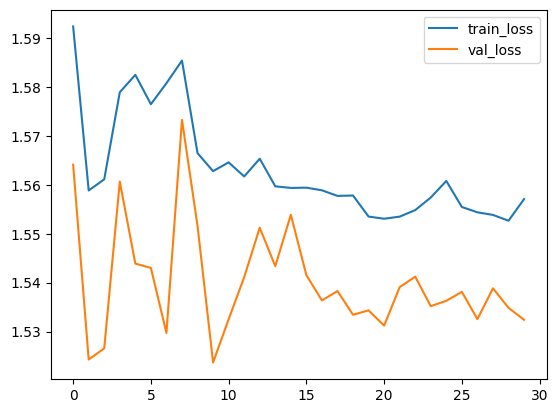

In [17]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

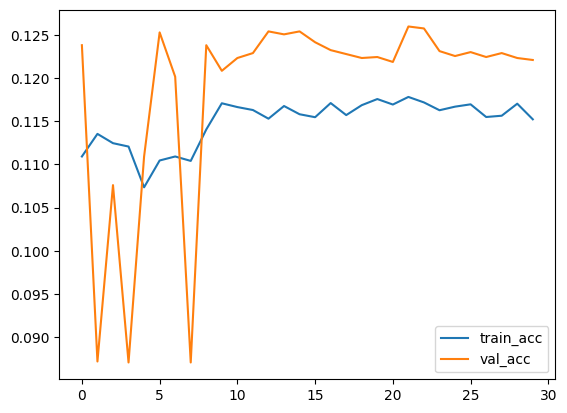

In [18]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'val_acc'])
plt.show()

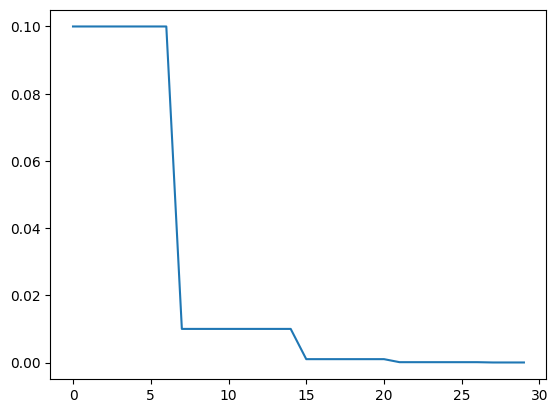

In [19]:
plt.plot(lr_list)
plt.show()